In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

from functions.datacleaning import MoscowHousing as mh
from functions.distance import get_distance_coordinates, norm_features

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from bs4 import BeautifulSoup
import re

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# Start web session for collecting coordinates to metro stations
service = Service('/usr/local/bin/chromedriver')
service.start()
driver = webdriver.Remote(service.service_url)
driver.get('https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations')

# Get content from web page
content = driver.page_source

# Find all spans with coordinates
soup = BeautifulSoup(content, features="html.parser")
spans = soup.find_all('span', class_="geo-dec")
driver.quit()

# Collect coordinates for all metro stations in Moscow
coordinates = []
numbers = re.compile(r'\d+(?:\.\d+)?')
# iterate all spans with coordinates
for span in spans:
    coord = span.get_text()
    coord = numbers.findall(coord)
    coord = [float(x) for x in coord]
    coordinates.append(tuple(coord))

# Close browser connection
driver.quit()

In [35]:
print(type(coordinates))

<class 'list'>


In [28]:
#print(coordinates)

[(55.8148, 37.7342), (55.8038, 37.7448), (55.7963, 37.7151), (55.7888, 37.6802), (55.7801, 37.6673), (55.7753, 37.6562), (55.769, 37.6487), (55.7657, 37.6388), (55.7597, 37.6272), (55.7577, 37.6166), (55.7512, 37.61), (55.7453, 37.6037), (55.7356, 37.5943), (55.7267, 37.5786), (55.7233, 37.5639), (55.7103, 37.5592), (55.6926, 37.5333), (55.6771, 37.506), (55.6637, 37.4833), (55.6459, 37.4725), (55.633, 37.4419), (55.6227, 37.424), (55.601367, 37.407645), (55.586242, 37.433802), (55.568643, 37.459332), (55.560396, 37.46822), (55.8791, 37.4822), (55.8658, 37.4764), (55.8549, 37.4761), (55.8398, 37.4867), (55.819, 37.498), (55.8051, 37.5153), (55.8003, 37.5329), (55.7897, 37.558), (55.7767, 37.5835), (55.7701, 37.5958), (55.7647, 37.6065), (55.7578, 37.619), (55.7415, 37.6295), (55.7305, 37.6377), (55.7074, 37.6576), (55.695, 37.6641), (55.6785, 37.6638), (55.6551, 37.6487), (55.6358, 37.6564), (55.6214, 37.6694), (55.6132, 37.6949), (55.6108, 37.7186), (55.6137, 37.7444), (55.6326, 37.76

In [32]:
coordinates_df = pd.DataFrame(coordinates,columns=["latitude", "longitude"])

In [33]:
coordinates_df.head()

,latitude,longitude
0,55.8148,37.7342
1,55.8038,37.7448
2,55.7963,37.7151
3,55.7888,37.6802
4,55.7801,37.6673


In [34]:
coordinates_df.to_csv("moscow_metros.csv", index=False)

In [4]:
# Get data
data = mh(coordinates)
features = ["area_total", "distance", "distance_metro", "floor", "district"]
XTrain, YTrain = data.get_data_train()
XTest = data.get_data_test()

X_Train = XTrain.copy() # Keep originals
X_Test = XTest.copy()   #
Y_Train = YTrain.copy() #

In [5]:
XTrain.to_csv("train_prepared.csv", index=False)
XTest.to_csv("test_prpared.csv", index=False)

In [6]:
XTrain.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,0,18450,NaN,11300000.0,-0.011096,153116.531165,-0.541037,0.263027,1,3,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,-0.315749,286.45
1,1,20065,1.0,7100000.0,-0.553098,169047.619048,-0.388730,-0.596888,5,1,...,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0,2.903551,16183.78
2,2,2137,0.0,13600000.0,0.009357,181333.333333,-0.388730,0.517816,3,3,...,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0,-0.051469,956.44
3,3,4155,1.0,10100000.0,-0.263348,171186.440678,NaN,NaN,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,1405.21
4,3,8798,1.0,10100000.0,-0.263348,171186.440678,-0.084116,-0.262477,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,1405.21


In [7]:
XTest.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,4,26052,NaN,5.675295,NaN,NaN,3,6,NaN,NaN,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,0.293752,4981.58
1,5,29404,1.0,-0.896821,-1.581108,-0.588336,1,1,NaN,-0.077026,...,3.0,12,0.0,1.0,0.0,NaN,1.0,NaN,0.116589,499.31
2,6,24089,2.0,0.494253,-0.417982,0.678815,3,4,1.0,-0.068230,...,3.0,22,0.0,1.0,1.0,1.0,1.0,0.0,-0.040901,1123.52
3,11,24033,0.0,0.087932,0.163582,0.165921,11,3,NaN,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,955.56
4,11,32976,1.0,0.096804,-0.316208,0.368062,5,3,1.0,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,955.56


In [8]:
# Prepare test data for modeling
#test_features = data.features_final
test_features = features
X_Test = X_Test[test_features]
X_Train = X_Train[features]

In [9]:
XTrain.shape  # Should be 9937 examples

(23285, 38)

In [10]:
XTest.head()  # All features

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,4,26052,NaN,5.675295,NaN,NaN,3,6,NaN,NaN,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,0.293752,4981.58
1,5,29404,1.0,-0.896821,-1.581108,-0.588336,1,1,NaN,-0.077026,...,3.0,12,0.0,1.0,0.0,NaN,1.0,NaN,0.116589,499.31
2,6,24089,2.0,0.494253,-0.417982,0.678815,3,4,1.0,-0.068230,...,3.0,22,0.0,1.0,1.0,1.0,1.0,0.0,-0.040901,1123.52
3,11,24033,0.0,0.087932,0.163582,0.165921,11,3,NaN,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,955.56
4,11,32976,1.0,0.096804,-0.316208,0.368062,5,3,1.0,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,955.56


In [11]:
X_Test.head()  # Only with features

,area_total,distance,distance_metro,floor,district
0,5.675295,0.293752,4981.58,3,8
1,-0.896821,0.116589,499.31,1,1
2,0.494253,-0.040901,1123.52,3,2
3,0.087932,0.074818,955.56,11,2
4,0.096804,0.074818,955.56,5,2


In [12]:
X = X_Train.copy() # Keep prepared "originals" (the real orig = XTrain)
y = Y_Train.copy() #

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoostRegressor

In [13]:
# Kaggle score on this prediction is: 0.29393 (best single model performance until now)

modelCBR = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.008,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

"""
1. Default from Ensembele ---------------------> mse 0.36905
2. change n_estimators = 1000 (default 500) ---> mse 0.36763 # Choose this 1000
3. change n_estimators = 5000 -----------------> mse 0.37690
4. n_estim = 1000 lr = 0.08 (default 0.1) -----> mse 0.36366

5. removing district and rooms ----------------> mse 0.35049
6. removing rooms -----------------------------> mse 0.33331 # Choose this

7.  lr = 0.04 ---------------------------------> mse 0.32079
8.  lr = 0.02 ---------------------------------> mse 0.32118
9.  lr = 0.009 --------------------------------> mse 0.31140
10. lr = 0.008 --------------------------------> mse 0.31097 # Choose this 0.008

11. depth = 10 (default 7) --------------------> mse 0.32140
12. depth = 9 ---------------------------------> mse 0.31622 # Choose default 7

13. added "distance_metro" (not normalized, m) > mse 0.29202 # Choose this

"""

'\n1. Default from Ensembele ---------------------> mse 0.36905\n2. change n_estimators = 1000 (default 500) ---> mse 0.36763 # Choose this 1000\n3. change n_estimators = 5000 -----------------> mse 0.37690\n4. n_estim = 1000 lr = 0.08 (default 0.1) -----> mse 0.36366\n\n5. removing district and rooms ----------------> mse 0.35049\n6. removing rooms -----------------------------> mse 0.33331 # Choose this\n\n7.  lr = 0.04 ---------------------------------> mse 0.32079\n8.  lr = 0.02 ---------------------------------> mse 0.32118\n9.  lr = 0.009 --------------------------------> mse 0.31140\n10. lr = 0.008 --------------------------------> mse 0.31097 # Choose this 0.008\n\n11. depth = 10 (default 7) --------------------> mse 0.32140\n12. depth = 9 ---------------------------------> mse 0.31622 # Choose default 7\n\n13. added "distance_metro" (not normalized, m) > mse 0.29202 # Choose this\n\n'

In [14]:
modelCBR.fit(X_train, y_train)

In [15]:
cat_prediction = modelCBR.predict(X_test)

In [16]:
cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)

Test MSE: 0.29202


In [17]:
cat_prediction_REAL = modelCBR.predict(XTest[features])

In [18]:
# Kaggle score on this prediction is: 0.29393 (best single performance until now)
data.write_results("cat_prediction.csv", cat_prediction_REAL)

Text(0, 0.5, 'Ground Truth')

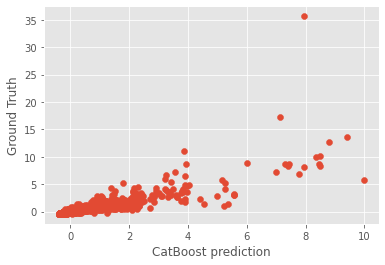

In [19]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

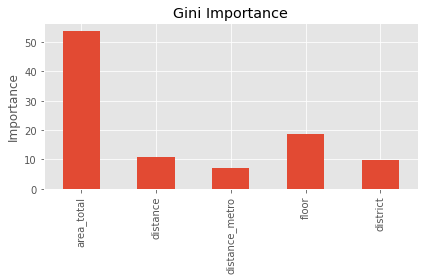

In [20]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

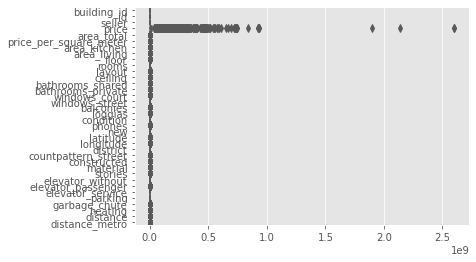

In [21]:
ax = sns.boxplot(data=XTrain, orient="h", palette="Set2")

Text(0, 0.5, 'Ground Truth')

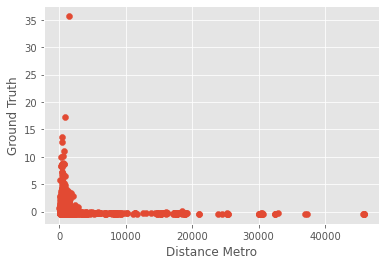

In [22]:
plt.scatter((X_test["distance_metro"]), y_test)
plt.xlabel('Distance Metro')
plt.ylabel('Ground Truth')